## Go through the first part of the Pipeline for one subject

In [2]:
# Import Libraries
import mne
import subprocess
import wfdb
import os
import copy
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from nitime.analysis import MTCoherenceAnalyzer
from nitime.timeseries import TimeSeries
from nitime.algorithms import mtm_cross_spectrum
from datetime import timedelta
import sys

# Select Subject
# selected_subject = ["bi0002"]
selected_subject = ["bi0001", "bi0002", "bi0003", "bi0004", "bi0007", "bi0008", "bi0010"]

# Import Code
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.append(str(src_path))
os.chdir(project_root)
sys.argv = ["notebook", "--config", "/Users/alicealbrecht/wynton_home/PSG_Pipeline/config/mros_ses-1_config.yaml"] 

from config.read_config import read_config
from pipeline_io.get_mastersheet import get_mastersheet
from pipeline_io.edf_to_h5 import edf_to_h5
from pipeline_io.read_annot import read_annot
from analysis.process_sleep_stages import process_sleep_stages
from analysis.process_signals import process_signals
from analysis.selecting_windows import selecting_windows
from features.extract_features import extract_features
from pipeline_io.save_features import save_features, save_features_wide

# Run first part of the code 
config, config_path = read_config()
mastersheet = get_mastersheet(config)
rows = mastersheet.sort_values("sub_id").to_dict(orient="records")
rows = [row for row in rows if row["sub_id"] in selected_subject]

# Adjust the mastersheet with local paths
for row in rows:
    for key in ["annot_path", "edf_path"]:  # replace with relevant columns
        if key in row and not pd.isna(row[key]):
            row[key] = row[key].replace(
                "/wynton/group/andrews/data/",
                "/Users/alicealbrecht/wynton_data/"
            )

for row in rows:
    for key in ["h5_path", "events_path", "extracted_features_path"]:
        if key in row and row[key] is not None:
            row[key] = row[key].replace(
                "/wynton/group/andrews/data/",
                "/Users/alicealbrecht/Desktop/"
            )

# Convert EDF to H5
# edf_to_h5(config, rows)

# Select one row
for row in rows:
    print("----- Processing Subject:", row["sub_id"], "-----")
    sub_key = f"{config.dataset.name.lower()}_ses-{config.dataset.session}_sub-{row['sub_id']}"
    project_root = Path("/Users/alicealbrecht/wynton_home/PSG_Pipeline")
    tmp_dir = project_root / "tmp" 
    tmp_dir_sub = tmp_dir / f"{row['sub_id']}"
    tmp_dir_sub.mkdir(parents=True, exist_ok=True)


    # Read annotation XML file
    full_sleep_stages, df_events = read_annot(
        row, config.dataset.name)

    # Get sleep stages only for the night part
    sleep_stages, sleep_onset_time = process_sleep_stages(
        full_sleep_stages, 
        sfreq_global = row["sfreq_global"],
        start_time = row["start_time"],
        verbose = config.run.verbose)

    processed_signals = process_signals(
        config, 
        row,
        full_sleep_stages,
        tmp_dir_sub)

    windows_dict = None
    if config.features.extract_all or any(f in config.features.selected for f in ["hrv", "cpc"]):
        windows_dict = selecting_windows(
            config,
            row,
            sleep_stages, 
            sleep_onset_time,
            processed_signals)

    extracted_features = extract_features(config, row, tmp_dir_sub, sleep_stages, sleep_onset_time, processed_signals, df_events, windows_dict)

    save_features(config, row, extracted_features)
    save_features_wide(config, row, extracted_features)

[INFO] Loading existing mastersheet from /Users/alicealbrecht/Desktop/PSG_Pipeline_Outputs/mastersheets/mros_ses-1_mastersheet.csv
----- Processing Subject: bi0001 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0002 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0003 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0004 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0007 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0008 -----
Option -softwareopengl does not apply on MAC.
----- Processing Subject: bi0010 -----
Option -softwareopengl does not apply on MAC.


In [8]:
from itertools import groupby
epoch_length_sec = 30
extended_sleep_stages = np.array([s for s, g in groupby(full_sleep_stages) for _ in range(len(list(g)) * epoch_length_sec)])

In [5]:
df_events.iloc[12:25]

,onset,duration,sleep_stage,event_type,channel,lowest_spo2,desaturation
12,109.9,1.2,NaN,limb_movement_(right),leg_r,NaN,NaN
13,120.0,30.0,0.0,NaN,NaN,NaN,NaN
14,123.2,2.1,NaN,limb_movement_(right),leg_r,NaN,NaN
15,135.6,4.5,NaN,limb_movement_(right),leg_r,NaN,NaN
16,150.0,30.0,0.0,NaN,NaN,NaN,NaN
17,152.0,7.0,NaN,spo2_desaturation,sao2,95,2
18,169.3,0.7,NaN,limb_movement_(right),leg_r,NaN,NaN
19,180.0,30.0,0.0,NaN,NaN,NaN,NaN
20,201.6,0.7,NaN,limb_movement_(right),leg_r,NaN,NaN
21,210.0,30.0,0.0,NaN,NaN,NaN,NaN


## Optional plots

Number of detected R-peaks: 27533
RR intervals (s): mean=1.108, min=0.516, max=45.141
Mean heart rate: 54.1 bpm
Max RR interval at time: 6614.01 seconds


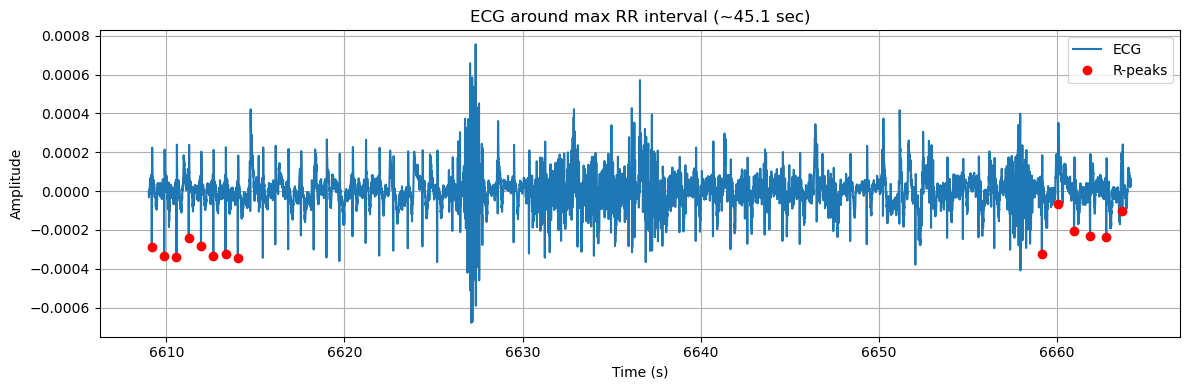

In [13]:
import matplotlib.pyplot as plt
import numpy as np

ecg_signal = ecg_data["signal"]
rpeaks = ecg_data["clean_rpeaks"]
sfreq = ecg_data["sfreq_signal"]
t = np.arange(len(ecg_signal)) / sfreq

rri_samples = np.diff(rpeaks)
rri_sec = rri_samples / sfreq
mean_rr = np.mean(rri_sec)
min_rr = np.min(rri_sec)
max_rr = np.max(rri_sec)
mean_hr = 60 / mean_rr  # bpm

print(f"Number of detected R-peaks: {len(rpeaks)}")
print(f"RR intervals (s): mean={mean_rr:.3f}, min={min_rr:.3f}, max={max_rr:.3f}")
print(f"Mean heart rate: {mean_hr:.1f} bpm")

max_rr_index = np.argmax(rri_sec)
print(f"Max RR interval at time: {rpeaks[max_rr_index] / sfreq:.2f} seconds")

# Get full RR interval bounds
start_sample = rpeaks[max_rr_index]
end_sample = rpeaks[max_rr_index + 1]

# Add ±5 seconds buffer (converted to samples)
buffer = int(5 * sfreq)
window_start = max(start_sample - buffer, 0)
window_end = min(end_sample + buffer, len(ecg_signal))

# Select R-peaks in the window
mask = (rpeaks >= window_start) & (rpeaks <= window_end)
rpeaks_selected = rpeaks[mask]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t[window_start:window_end], ecg_signal[window_start:window_end], label="ECG")
plt.plot(rpeaks_selected / sfreq, ecg_signal[rpeaks_selected], "ro", label="R-peaks")
plt.title(f"ECG around max RR interval (~{rri_sec[max_rr_index]:.1f} sec)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Get EDR adn RRI aligned and downsampled

In [ ]:

def get_edr_from_ecg(ecg_signal, rpeaks, sfreq_ecg, tmp_dir_sub):
    """
    Runs external EDR tool and returns (sample_indices, edr_values).
    Does not interpolate to ECG timeline.
    """
    edr_module = "/Users/alicealbrecht/wynton_home/PSG_Pipeline/src/external_tools/c_modules/edr_macOS"
    sub_id = Path(tmp_dir_sub).name
    edr_file = tmp_dir_sub / f"edr_{sub_id}_output.txt"
    record_name = "rec"

    # Write temporary ECG signal and annotations
    wfdb.wrsamp(
        record_name,
        fs=sfreq_ecg,
        units=['uV'],
        sig_name=['ECG'],
        p_signal=ecg_signal.reshape(-1, 1),
        write_dir=str(tmp_dir_sub),
    )

    wfdb.wrann(
        record_name,
        extension='atr',
        sample=rpeaks,
        label_store=np.ones(len(rpeaks), dtype=int),
        fs=sfreq_ecg,
        write_dir=str(tmp_dir_sub),
    )

    # --- Fix: set LD_LIBRARY_PATH for subprocess ---
    env = os.environ.copy()
    wfdb_lib_dir = "/wynton/home/leng/alice-albrecht/projects/wfdb/lib"
    env["LD_LIBRARY_PATH"] = env.get("LD_LIBRARY_PATH", "") + f":{wfdb_lib_dir}"

    # Run external EDR binary
    with open(edr_file, "w") as f:
        subprocess.check_call(
            [str(edr_module), "-r", record_name, "-i", "atr", "-v"],
            cwd=tmp_dir_sub,
            stdout=f,
            env=env,   
        )
        
    # Load output 
    df_edr = pd.read_csv(edr_file, header=None,  sep=r'\s+')
    # exclude first index and value to align with RRI assigned to ending R-peak 
    edr_indices = df_edr[0].values[1:]
    edr_values = df_edr[1].values[1:] 

    return edr_indices, edr_values


In [169]:
def resample_rri_edr(ecg_signal, rpeaks, sfreq_ecg, config, tmp_dir_sub):
    # --- Step 1: Compute RRI ---
    rri_values = np.diff(rpeaks)
    rri_indices = rpeaks[1:] # assign RRI to the second R-peak

    # --- Step 2: Filter RRI based on config ---
    min_rri_samples = config.analysis.min_rri_sec * sfreq_ecg
    max_rri_samples = config.analysis.max_rri_sec * sfreq_ecg
    valid_mask = (rri_values >= min_rri_samples) & (rri_values <= max_rri_samples)
    rri_values_valid = rri_values[valid_mask]
    rri_indices_valid = rri_indices[valid_mask]

    # --- Step 3: Extract EDR from ECG ---
    # edr_indice is also in smaples exactly equal to rpeaks
    edr_indices, edr_values = get_edr_from_ecg(ecg_signal,
                                            rpeaks, 
                                            sfreq_ecg, 
                                            tmp_dir_sub)

    # Sanity check lengths (before masking RRI)
    print(f"RRI count: {len(rri_indices)}, EDR count: {len(edr_indices)}")
    # Not masking EDR since already compute only on clean R-peaks.

     # --- Step 4: Crop to overlapping region ---
    start_sec = max(rri_indices_valid.min(), edr_indices.min()) / sfreq_ecg
    stop_sec  = min(rri_indices_valid.max(), edr_indices.max()) / sfreq_ecg

    rri_mask_crop = (rri_indices_valid / sfreq_ecg >= start_sec) & (rri_indices_valid / sfreq_ecg <= stop_sec)
    edr_mask_crop = (edr_indices / sfreq_ecg >= start_sec) & (edr_indices / sfreq_ecg <= stop_sec)

    rri_indices_cropped = rri_indices_valid[rri_mask_crop]
    rri_values_cropped = rri_values_valid[rri_mask_crop]

    edr_indices_cropped = edr_indices[edr_mask_crop]
    edr_values_cropped = edr_values[edr_mask_crop]

    # --- Step 5: Interpolate to 2Hz timeline ---
    # Convert to seconds
    rri_times_sec = rri_indices_cropped / sfreq_ecg
    rri_sec = rri_values_cropped / sfreq_ecg
    edr_times_sec = edr_indices_cropped / sfreq_ecg
    edr_vals = edr_values_cropped

    # Create 2Hz timeline
    sfreq_final = 2.0
    dt = 1.0 / sfreq_final
    time_resampled = np.arange(start_sec, stop_sec, dt)

    # Interpolate using cubic splines
    rri_interp = interp1d(rri_times_sec, rri_sec, kind='cubic', bounds_error=False,fill_value=np.nan)
    edr_interp = interp1d(edr_times_sec, edr_vals, kind='cubic', bounds_error=False,fill_value=np.nan)
    rri_resampled = rri_interp(time_resampled)
    edr_resampled = edr_interp(time_resampled)

    # Remove any NaN values resulting from interpolation
    valid_mask = np.isfinite(rri_resampled) & np.isfinite(edr_resampled)
    time_resampled = time_resampled[valid_mask]
    rri_resampled = rri_resampled[valid_mask]
    edr_resampled = edr_resampled[valid_mask]

    return time_resampled, rri_resampled, edr_resampled

In [170]:
# --- Input ECG data ---
ecg_signal = ecg_data["signal"]
rpeaks = ecg_data["clean_rpeaks"]
sfreq_ecg = ecg_data["sfreq_signal"]

time_resampled, rri_resampled, edr_resampled = resample_rri_edr(ecg_signal, rpeaks, sfreq_ecg, config, tmp_dir_sub)

RRI count: 27532, EDR count: 27532


In [177]:
windows_dict["ECG_L"]['WN@100%']

{'count': 42,
 'timestamps': [datetime.datetime(2004, 9, 12, 22, 21, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 22, 26, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 22, 34, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 22, 47, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 22, 52, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 23, 4, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 23, 12, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 23, 28, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 23, 47, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 12, 23, 58, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 13, 0, 3, 58, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 13, 0, 9, 28, tzinfo=datetime.timezone.utc),
  datetime.datetime(2004, 9, 13, 0, 18, 28, tzinfo=datetime.timez

In [208]:
from nitime.analysis import MTCoherenceAnalyzer
from nitime.timeseries import TimeSeries
from nitime.algorithms import mtm_cross_spectrum

def get_cpc_features_window(rri_seg, edr_seg, fs,
                     freq_vl=[0, 0.01], freq_l=[0.01, 0.1], freq_h=[0.1, 0.4],
                     use_max_two=True): 

    # Compute cross-spectral coherence
    ts = TimeSeries(np.array([rri_seg, edr_seg]), sampling_rate=fs)
    analyzer = MTCoherenceAnalyzer(ts)

    freqs = analyzer.frequencies  # frequency bins
    coh = analyzer.coherence[0, 1]  # coherence between RRI and EDR

    # Cross spectral density (CSD)
    # CPC is coherence × |CSD|^2, using multitaper method
    csd = np.abs(mtm_cross_spectrum(analyzer.spectra[0], analyzer.spectra[1],
                                    (analyzer.weights[0], analyzer.weights[1]),
                                    sides='onesided')) ** 2

    cpc = coh * csd  # final CPC values across frequency bins

    # Compute band powers
    vlfc = band_power(cpc, freqs, freq_vl, use_max_two)
    lfc = band_power(cpc, freqs, freq_l, use_max_two)
    hfc = band_power(cpc, freqs, freq_h, use_max_two)

    # Log and ratio
    log_vlfc = safe_log(vlfc)
    log_lfc = safe_log(lfc)
    log_hfc = safe_log(hfc)
    log_vl2lh = log_vlfc - safe_log(lfc + hfc)
    log_h2l = log_hfc - log_lfc if not np.isnan(log_hfc) and not np.isnan(log_lfc) else np.nan


    cpc_features = {
        "log_pwr_VLFC": log_vlfc,
        "log_pwr_LFC": log_lfc,
        "log_pwr_HFC": log_hfc,
        "log_pwr_VL2LH": log_vl2lh,
        "log_pwr_H2L": log_h2l,
    }

    return cpc_features


# Other utils functions
def band_power(cpc_vals, f, band, use_max_two):
    # Extract CPC values in bands
    mask = (f >= band[0]) & (f < band[1])
    if use_max_two:
        top_vals = np.sort(cpc_vals[mask])[-2:]
        return np.sum(top_vals)
    else:
        return np.sum(cpc_vals[mask])
    
def safe_log(x):
    # Log-transformed powers and ratios
    return np.log(x) if x > 0 else np.nan


In [214]:
from datetime import timedelta

target_sfreq = 2.0
window_size_sec = config.analysis.window_size_min * 60
window_size_samples = int(window_size_sec * target_sfreq)
psg_id = Path(tmp_dir_sub).name

feat_names_cpc = ['log_pwr_VLFC', 'log_pwr_LFC', 'log_pwr_HFC',
                  'log_pwr_VL2LH', 'log_pwr_H2L']

features_by_stage = []

for stage_key, info in windows_dict.items():
    stage_type = stage_key.split('@')[0]
    timestamps = info.get('timestamps', [])

    # If no windows, return NaN for all features
    if not timestamps:
        features_by_stage.append({**{k: np.nan for k in feat_names_cpc}, 'stage_type': stage_type})
        continue

    # Compute window start indices relative to first resampled time
    trim_start_time = sleep_onset_time + timedelta(seconds=time_resampled[0])
    window_start_ids = [
        int(round((timestamp - trim_start_time).total_seconds() * target_sfreq))
        for timestamp in timestamps
    ]

    # Initialize storage for features
    feats_all_windows = {k: [] for k in feat_names_cpc}

    for start in window_start_ids:
        end = start + window_size_samples
        if end > len(time_resampled):
            continue

        rri_seg = rri_resampled[start:end]
        edr_seg = edr_resampled[start:end]

        if np.isnan(rri_seg).any() or np.isnan(edr_seg).any():
            print(f"[WARNING] Sub {psg_id}: rri_seg or edr_seg contain NaN values.")
            continue

        cpc_features = get_cpc_features_window(rri_seg, edr_seg, target_sfreq)
        for k in feat_names_cpc:
            feats_all_windows[k].append(cpc_features.get(k, np.nan))

    # If all windows were skipped, fill with NaN
    if not any(len(v) > 0 for v in feats_all_windows.values()):
        features_by_stage.append({**{k: np.nan for k in feat_names_cpc}, 'stage_type': stage_type})
        continue

    # Take mean across windows
    feat_stage = {k: np.nanmean(v) for k, v in feats_all_windows.items()}
    feat_stage['stage_type'] = stage_type
    features_by_stage.append(feat_stage)

features_by_stage

[{'log_pwr_VLFC': 15.850144614327766,
  'log_pwr_LFC': 15.500213674969183,
  'log_pwr_HFC': 2.9560154429849894,
  'log_pwr_VL2LH': 0.349395122444399,
  'log_pwr_H2L': -12.544198231984193,
  'stage_type': 'WN'},
 {'log_pwr_VLFC': 15.717623251918845,
  'log_pwr_LFC': 15.0049826209879,
  'log_pwr_HFC': 3.1135416323978826,
  'log_pwr_VL2LH': 0.7124941183661426,
  'log_pwr_H2L': -11.891440988590015,
  'stage_type': 'REM'},
 {'log_pwr_VLFC': 15.42387706269193,
  'log_pwr_LFC': 15.365932746867317,
  'log_pwr_HFC': 2.9875808122363092,
  'log_pwr_VL2LH': 0.05706676704284645,
  'log_pwr_H2L': -12.37835193463101,
  'stage_type': 'N2N3'}]

In [210]:
feats_all_windows

{'log_pwr_VLFC': [10.670025197370009,
  5.291193802787612,
  10.526166217344509,
  17.84052463532171,
  17.265666093557144,
  15.438913713318692,
  14.994478197352786,
  15.077429140315168,
  16.9574560645248,
  17.374229914784895,
  17.6902897542687,
  18.668025700839014,
  17.858224482163447,
  18.255342428240112,
  17.205345741520002,
  14.19388370398064,
  2.9311827623533597,
  18.2634122085578,
  18.952973640035584,
  18.030603494571643,
  18.04525914054504,
  17.50239687209272,
  16.55336948366929,
  12.174253566159148,
  3.3242018483943587,
  18.454765116050666,
  18.235512749782504,
  16.859564225240838,
  16.281823142471303,
  18.242171042602173,
  17.327680523073937,
  15.872841831325132,
  16.62873663421894],
 'log_pwr_LFC': [11.420629803943115,
  6.6675993143492285,
  11.025245187062502,
  17.132235769673194,
  16.52961156037563,
  14.653266921450134,
  14.183528958641817,
  14.268846563962118,
  16.095351625516184,
  16.57848739295828,
  16.940347641513856,
  17.9594799570

In [203]:
len(rri_resampled)

61011

In [200]:
sleep_onset_time

datetime.datetime(2004, 9, 12, 21, 30, 28, tzinfo=datetime.timezone.utc)

In [196]:
old_window_start_ids = [
        int(round((timestamp - sleep_onset_time).total_seconds() * target_sfreq))
        for timestamp in timestamps
    ]
old_window_start_ids

[6120,
 6720,
 7680,
 9360,
 16500,
 17820,
 18420,
 19080,
 20160,
 21600,
 22200,
 25140,
 27600,
 31560,
 33720,
 34320,
 34980,
 35580,
 36420,
 37140,
 37980,
 39060,
 39660,
 40260,
 40860,
 42660,
 44700,
 45300,
 48120,
 50880,
 52080,
 53460,
 57900]

In [194]:
window_start_ids

[6114,
 6714,
 7674,
 9354,
 16494,
 17814,
 18414,
 19074,
 20154,
 21594,
 22194,
 25134,
 27594,
 31554,
 33714,
 34314,
 34974,
 35574,
 36414,
 37134,
 37974,
 39054,
 39654,
 40254,
 40854,
 42654,
 44694,
 45294,
 48114,
 50874,
 52074,
 53454,
 57894]

In [185]:
from datetime import timedelta
sleep_onset_time + timedelta(seconds=timestamps[0])

TypeError: unsupported type for timedelta seconds component: datetime.datetime

In [164]:
rri_resampled

array([1.21679688, 1.20193249, 1.19702241, ..., 1.1100706 , 1.10129396,
       1.09528969])

In [165]:
edr_resampled

array([-33.        ,  -9.48640179,   7.23885521, ..., -54.52604147,
       -40.87504457, -42.80513865])

## Optional Plots to check results

In [ ]:
# --- Print Info ---
print(f"Original ECG length: {ecg_len}")
print(f"Sampling frequency (ECG): {sfreq_ecg}")
print(f"Downsampled to: 2.0 Hz")
print(f"Length of downsampled signals: {len(time_ds)}")
print(f"rri_ds shape: {rri_ds.shape}, edr_ds shape: {edr_ds.shape}, time_ds shape: {time_ds.shape}")

print(f"Downsampled RRI min/max: {np.min(rri_ds)}, {np.max(rri_ds)}")
print(f"Downsampled EDR min/max: {np.min(edr_ds)}, {np.max(edr_ds)}")
print(f"Downsampled RRI mean/std: {np.mean(rri_ds)}, {np.std(rri_ds)}")
print(f"Downsampled EDR mean/std: {np.mean(edr_ds)}, {np.std(edr_ds)}")
print(f"NaNs in downsampled RRI: {np.isnan(rri_ds).sum()}")
print(f"NaNs in downsampled EDR: {np.isnan(edr_ds).sum()}")

Original ECG length: 8632320
Sampling frequency (ECG): 512
Downsampled to: 2.0 Hz
Length of downsampled signals: 33720
rri_ds shape: (33720,), edr_ds shape: (33720,), time_ds shape: (33720,)
Downsampled RRI min/max: 0.5173420932302726, 2.8796248350930953
Downsampled EDR min/max: -0.2561090141484333, 0.2520271741472954
Downsampled RRI mean/std: 1.049244340180119, 0.21962186372992196
Downsampled EDR mean/std: 0.0035112520961699772, 0.09204312052510583
NaNs in downsampled RRI: 0
NaNs in downsampled EDR: 0


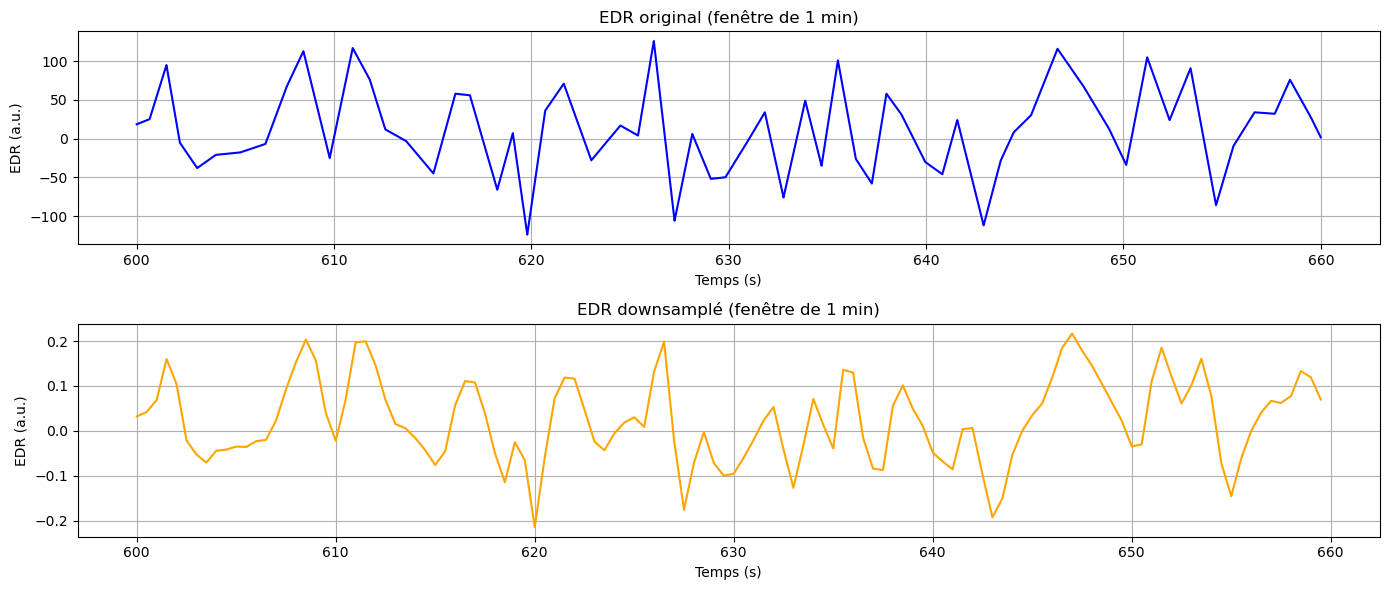

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
window_duration_s = 60  # Durée de la fenêtre : 1 minute
start_time_s = 600        # Temps de départ (en secondes), modifiable

end_time_s = start_time_s + window_duration_s

# Vecteurs temps
time_ecg = np.arange(ecg_len) / sfreq_ecg  # timeline original

# Indices pour extraire la fenêtre dans le signal original
idx_start_orig = int(start_time_s * sfreq_ecg)
idx_end_orig = int(end_time_s * sfreq_ecg)

# Indices pour extraire la fenêtre dans le signal downsamplé
idx_start_ds = np.searchsorted(time_ds, start_time_s)
idx_end_ds = np.searchsorted(time_ds, end_time_s)

# Extraire les segments
edr_orig_win = edr_on_ecg[idx_start_orig:idx_end_orig]
time_orig_win = time_ecg[idx_start_orig:idx_end_orig]

edr_ds_win = edr_ds[idx_start_ds:idx_end_ds]
time_ds_win = time_ds[idx_start_ds:idx_end_ds]

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(time_orig_win, edr_orig_win, color='blue')
plt.title("EDR original (fenêtre de 1 min)")
plt.xlabel("Temps (s)")
plt.ylabel("EDR (a.u.)")
plt.grid(True)
plt.ylim(np.nanmin(edr_orig_win)*1.1, np.nanmax(edr_orig_win)*1.1)

plt.subplot(2, 1, 2)
plt.plot(time_ds_win, edr_ds_win, color='orange')
plt.title("EDR downsamplé (fenêtre de 1 min)")
plt.xlabel("Temps (s)")
plt.ylabel("EDR (a.u.)")
plt.grid(True)
plt.ylim(np.nanmin(edr_ds_win)*1.1, np.nanmax(edr_ds_win)*1.1)

plt.tight_layout()
plt.show()


## Full Def to extract cpc

In [ ]:
from nitime.analysis import MTCoherenceAnalyzer
from nitime.timeseries import TimeSeries
from nitime.algorithms import mtm_cross_spectrum
from scipy.stats import linregress

def extract_cpc(config, sleep_onset_time, ecg_data, windows_dict):
    feat_names_cpc = ['stable%', 'unstable%', 'R+W%',
        'log_pwr_HFC', 'log_pwr_LFC', 'log_pwr_VLFC',
        'log_pwr_H2L', 'log_pwr_VL2LH']
    
    sfreq_ecg = ecg_data["sfreq_signal"]
    rpeaks = ecg_data["clean_rpeaks"]

    # Compute EDR (part diff form HRV)
    ecg_signal = ecg_data["signal"]
    ecg_len = len(ecg_signal)
    edr_path = "/Users/alicealbrecht/Documents/GitHub/PSG-Pipeline/src/external_tools/c_modules/edr/edr"
    target_sfreq = 2.0


    # --- Step 1: Extract EDR from ECG ---
    edr_sample_indices, edr_values = get_edr_from_ecg(ecg_signal, 
                                                    rpeaks, 
                                                    sfreq_ecg, 
                                                    edr_path)

    # --- Step 2: Align EDR to ECG sample timeline ---
    edr_on_ecg = align_edr_to_ecg_timeline(edr_sample_indices, 
                                        edr_values,
                                        ecg_len)

    # --- Step 3: Align RRI to ECG sample timeline ---
    rri_on_ecg = align_rri_to_ecg_timeline(rpeaks, ecg_len, sfreq_ecg)

    # --- Step 4: Downsample RRI and EDR ---
    rri_ds, edr_ds, time_ds = downsample_rri_edr(
        rri_interp_samples=rri_on_ecg,
        edr_values_samples=edr_on_ecg,
        sfreq_ecg=sfreq_ecg,
        target_sfreq=target_sfreq)

    # Window size and step in seconds and samples at downsampled rate
    epoch_length_sec = 30 
    window_size_sec = config.analysis.window_size_min * 60
    window_step_sec = config.analysis.window_step_epochs * epoch_length_sec
    window_size_samples = int(window_size_sec * target_sfreq)
    window_step_samples = int(window_step_sec * target_sfreq)

    ### Back to hrv code
    features_by_stage = []

    for stage_key, info in windows_dict.items():
        stage_type = stage_key.split('@')[0]
        timestamps = info['timestamps']

        if not timestamps:
            feat_stage = {x: np.nan for x in feat_names_cpc}
            feat_stage['stage_type'] = stage_type
            features_by_stage.append(feat_stage)
            continue

        window_start_ids = [int(round((timestamp - sleep_onset_time).total_seconds() * target_sfreq)) for timestamp in timestamps]

        feats_all_windows = {}

        for start in window_start_ids:
            end = start + window_size_samples
            if end > len(rri_ds):
                continue

            rri_seg = rri_ds[start:end]
            edr_seg = edr_ds[start:end]
            
            if np.isnan(rri_seg).any() or np.isnan(edr_seg).any():
                print("rri_seg or edr_seg contain NaN values.")
                continue

            feats = get_cpc_features(rri_seg, edr_seg, target_sfreq)
            if not feats_all_windows:
                feats_all_windows = {k: [v] for k, v in feats.items()}
            else:
                for k in feats:
                    feats_all_windows[k].append(feats[k])

        if not feats_all_windows:
            feat_stage = {x: np.nan for x in feat_names_cpc}
            feat_stage['stage_type'] = stage_type
            features_by_stage.append(feat_stage)
            continue


        # compute stability from raw CPC (not log values)
        stability_feats = compute_stability_flags(feats_all_windows, stage_type)

        # Mean values on windows and add stability info
        for k in feats_all_windows:
            feats_all_windows[k] = np.nanmean(feats_all_windows[k])
        feats_all_windows.update(stability_feats)

        # Now filter only features you want
        feat_stage = {k: feats_all_windows.get(k, np.nan) for k in feat_names_cpc}
        feat_stage['stage_type'] = stage_type

        features_by_stage.append(feat_stage)


    return features_by_stage

def nandetrend(x, axis=0):
    def f_(x):
        t = np.arange(len(x))
        ids = ~np.isnan(x)
        if ids.sum() < 2:
            return x
        res = linregress(t[ids], x[ids])
        detrended = x - (t*res[0] + res[1])
        detrended[~ids] = np.nan
        return detrended
    return np.apply_along_axis(f_, axis, x)


# Extract CPC values in bands
def band_power(cpc_vals, f, band, use_max_two):
    mask = (f >= band[0]) & (f < band[1])
    if use_max_two:
        top_vals = np.sort(cpc_vals[mask])[-2:]
        return np.sum(top_vals)
    else:
        return np.sum(cpc_vals[mask])
    
# Log-transformed powers and ratios
def safe_log(x):
    return np.log(x) if x > 0 else np.nan

def get_cpc_features(rri_seg, edr_seg, fs,
                     freq_vl=[0, 0.01], freq_l=[0.01, 0.1], freq_h=[0.1, 0.4],
                     use_max_two=False): 

    # Compute cross-spectral coherence
    ts = TimeSeries(np.array([rri_seg, edr_seg]), sampling_rate=fs)
    analyzer = MTCoherenceAnalyzer(ts)

    freqs = analyzer.frequencies  # frequency bins
    coh = analyzer.coherence[0, 1]  # coherence between RRI and EDR

    # Cross spectral density (CSD)
    # CPC is coherence × |CSD|^2, using multitaper method
    csd = np.abs(mtm_cross_spectrum(analyzer.spectra[0], analyzer.spectra[1],
                                    (analyzer.weights[0], analyzer.weights[1]),
                                    sides='onesided')) ** 2

    cpc = coh * csd  # final CPC values across frequency bins

    vlfc = band_power(cpc, freqs, freq_vl, use_max_two)
    lfc = band_power(cpc, freqs, freq_l, use_max_two)
    hfc = band_power(cpc, freqs, freq_h, use_max_two)

    # Avoid division by zero
    ratio_l2h = lfc / hfc if hfc != 0 else np.nan
    ratio_vl2lh = vlfc / (lfc + hfc) if (lfc + hfc) != 0 else np.nan
    # Log and ratio dict (your existing CPC features)
    log_vlfc = safe_log(vlfc)
    log_lfc = safe_log(lfc)
    log_hfc = safe_log(hfc)
    log_h2l = log_hfc - log_lfc if not np.isnan(log_hfc) and not np.isnan(log_lfc) else np.nan
    log_vl2lh = log_vlfc - safe_log(lfc + hfc)

    cpc_feats = {
        "pwr_VLFC": vlfc,
        "pwr_LFC": lfc,
        "pwr_HFC": hfc,
        "ratio_L2H": ratio_l2h,
        "ratio_VL2LH": ratio_vl2lh ,
        "log_pwr_VLFC": log_vlfc,
        "log_pwr_LFC": log_lfc,
        "log_pwr_HFC": log_hfc,
        "log_pwr_H2L": log_h2l,
        "log_pwr_VL2LH": log_vl2lh,
    }

    return cpc_feats

def compute_stability_flags(cpc_feats, stage_type):
    """
    Compute %stable, %unstable, %REM+Wake windows based on CPC ratios and thresholds.
    """
    hfc = np.array(cpc_feats["pwr_HFC"])
    lfc = np.array(cpc_feats["pwr_LFC"])
    vlfc = np.array(cpc_feats["pwr_VLFC"])
    ratio_l2h = np.array(cpc_feats["ratio_L2H"])
    ratio_vl2lh = np.array(cpc_feats["ratio_VL2LH"])

    # Remove NaNs for threshold computation
    hfc_valid = hfc[~np.isnan(hfc)]
    lfc_valid = lfc[~np.isnan(lfc)]
    vlfc_valid = vlfc[~np.isnan(vlfc)]

    if stage_type == 'WN' and len(hfc_valid) >= 1:
        hfc_max = np.percentile(hfc_valid, 99)
        lfc_max = np.percentile(lfc_valid, 99)
        vlfc_max = np.percentile(vlfc_valid, 99)
    else:
        # Avoid divide-by-zero
        hfc_max = lfc_max = vlfc_max = 1.0

    stable = (ratio_l2h < 2) & (hfc / hfc_max > 0.02)
    unstable = (ratio_l2h > 2) & (lfc / lfc_max > 0.2)
    rem_w = (ratio_vl2lh > 0.2) & (vlfc / vlfc_max > 0.05)

    return {
        "stable%": 100 * np.nanmean(stable),
        "unstable%": 100 * np.nanmean(unstable),
        "R+W%": 100 * np.nanmean(rem_w)
    }

def collapse_stage_features_to_dict(features_by_stage):
    """
    Convert list of feature dicts per stage into a flat dict with keys like 'sdnn@WN'.
    """
    flat = {}
    for entry in features_by_stage:
        stage = entry.get("stage_type", "unknown")
        for k, v in entry.items():
            if k == "stage_type":
                continue
            flat[f"{k}@{stage}"] = v
    return flat

cpc_features = extract_cpc(config, sleep_onset_time, ecg_data, windows_dict)
pd.DataFrame(cpc_features).set_index("stage_type")

/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_33738/1731010029.py:42: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_edr = pd.read_csv(output_file, header=None, delim_whitespace=True)


ℹ️ NaNs in interpolated RRI: 12240 / 8632320 (0.14%)


,stable%,unstable%,R+W%,log_pwr_HFC,log_pwr_LFC,log_pwr_VLFC,log_pwr_H2L,log_pwr_VL2LH
stage_type,,,,,,,,
WN,21.739130,26.086957,26.086957,-3.843838,-1.053636,-0.941048,-2.790202,-0.135013
REM,12.500000,37.500000,75.000000,-3.738712,-1.695413,-1.706751,-2.043300,-0.355347
N2N3,9.090909,45.454545,54.545455,-3.826376,-1.530838,-1.694487,-2.295538,-0.423773
